# Various imports

## Visualization and data manipulation tools

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## Pipeline creation and preprocessing tools

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.base import BaseEstimator,TransformerMixin

## MLFlow

In [30]:
import mlflow
from urllib.parse import urlparse

mlflow.get_tracking_uri()

'file:///Users/rom1/Documents/VSCode/houses_linear_reg/mlruns'

## Other tools and model

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression

# Import and split data

In [34]:
df = pd.read_csv("kc_house_data_clean.csv")

X = df.drop(["price", "sqft_living15", "sqft_lot15"], axis=1) # , "mean_lat_distance", "mean_long_distance", "lat", "long",, "sqft_living"
y = df["price"]
# y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)# random_state=42)

X_test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'],
      dtype='object')

# Pipeline

## Custom transformer

In [35]:
class MakeDistance(BaseEstimator, TransformerMixin):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def fit(self, X, y):
        self.check_columns(X)

        n_priciest = y.sort_values(inplace=False).tail(self.n)

        n_priciest_pos = X.loc[n_priciest.index]

        self.mean_lat = n_priciest_pos["lat"].mean()
        self.mean_long = n_priciest_pos["long"].mean()

        return self

    def transform(self, X, y=None):
        self.check_columns(X)
        mean_lat_distance = X["lat"] - self.mean_lat
        mean_long_distance = X["long"] - self.mean_long

        return np.sqrt(mean_lat_distance**2 + mean_long_distance**2).to_frame()

    def check_columns(self, X):
        if X.shape[1] != 2:
            raise Exception(f"MakeDistance takes two columns, {X.shape[1]} were given")

## Actual pipeline

In [36]:
log_pipeline = make_pipeline(
    SimpleImputer(), FunctionTransformer(np.log1p), PolynomialFeatures(degree=3), StandardScaler() # try without simpleimputer and standardscaler
)
zipcode_pipeline = make_pipeline(SimpleImputer(), OneHotEncoder())

other_pipeline = make_pipeline(SimpleImputer(), PolynomialFeatures(degree=2), StandardScaler()
)

log_features = ["sqft_lot", "sqft_above", "sqft_basement", "sqft_living"]#, "sqft_living15", "sqft_lot15", "sqft_living"]

preprocessor = make_column_transformer(
    (log_pipeline, log_features),
    (zipcode_pipeline, ["zipcode"]),
    (SimpleImputer(), ["waterfront"]),
    (MakeDistance(600), ["lat", "long"]),
    remainder=other_pipeline
)

In [37]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'],
      dtype='object')

# Metrics

In [38]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mae, np.sqrt(mse), r2

# Model

In [39]:
mlflow.sklearn.autolog()
with mlflow.start_run(experiment_id=0):

    model = make_pipeline(preprocessor, LinearRegression())
    y_preprocessor = FunctionTransformer(np.log, inverse_func=np.exp)

    model.fit(X_train, y_preprocessor.transform(y_train))
    y_pred = model.predict(X_test)

    mae, rmse, r2 = eval_metrics(y_test, y_preprocessor.inverse_transform(y_pred))
    print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("rmse_test", rmse)
    mlflow.log_metric("r2_test", r2)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
            model, "model", registered_model_name="linear_regression"
        )
    else:
        mlflow.sklearn.log_model(model, "model")

2022/03/11 16:22:18 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                            ('polynomialfeatures',
                                             PolynomialFeatures()),
         ...`
2022/03/11 16:22:18 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                            ('polynomialfeatures',
                                             PolynomialFeatures()),
                                ...`
2022/03/11 16:22:18 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline-1', Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('functiontransformer',
                 FunctionTransformer(func=<ufunc '

MAE: 69262.79211569233
RMSE: 123049.99671289395
R2: 0.8893264242205488


## Cross validation test

In [40]:
scores = cross_validate(model, X_train, y_preprocessor.transform(y_train), verbose=3, cv=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.890 total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ......................................., score=0.887 total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ......................................., score=0.888 total time=   0.3s
[CV] END ......................................., score=0.883 total time=   0.3s
[CV] END ......................................., score=0.893 total time=   0.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [41]:
r2_scores = scores["test_score"]
print(f"Best score : {r2_scores.max()}\nWorst score : {r2_scores.min()}\nAverage score : {r2_scores.mean()}")
raise

Best score : 0.8934804546721011
Worst score : 0.8826603404342122
Average score : 0.8882799192483745


RuntimeError: No active exception to reraise

In [ ]:
# param_grid = {'columntransformer__pipeline-1__polynomialfeatures__degree': np.arange(4), 'columntransformer__remainder__polynomialfeatures__degree': np.arange(4)}
param_grid = {'columntransformer__makedistance__n': np.arange(500, 1500, 100)}
grid = GridSearchCV(model, param_grid=param_grid, cv=5)

In [ ]:
grid.fit(X_train, y_train)
grid.best_params_

2022/03/09 21:45:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d0c517cc6504d5c9e8efda25ef04891', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/09 21:45:01 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer()),
                                                  ...`
2022/03/09 21:45:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inferenc

{'columntransformer__makedistance__n': 600}

# Some more analysis

## SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
X100 = shap.utils.sample(X, 100)

In [ ]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

Permutation explainer:   2%|▏         | 333/21593 [00:49<1:05:40,  5.39it/s]


KeyboardInterrupt: 

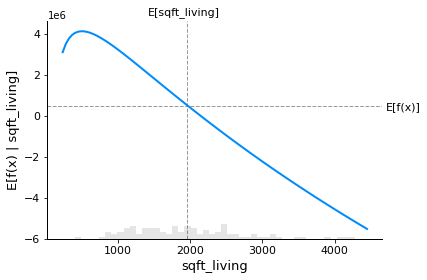

In [ ]:
sample_ind=18
shap.plots.partial_dependence(
  "sqft_living", model.predict, X100, ice=False,
  model_expected_value=True, feature_expected_value=True,
  shap_values=shap_values[sample_ind:sample_ind+1,:]
)

In [ ]:
shap.summary_plot(
    shap_values,
    preprocessor.transform(X),
    feature_names=preprocessor.get_feature_names_out(),
    plot_size=(20,15),
)

## Regplots

<AxesSubplot:xlabel='price', ylabel='sqft_living'>

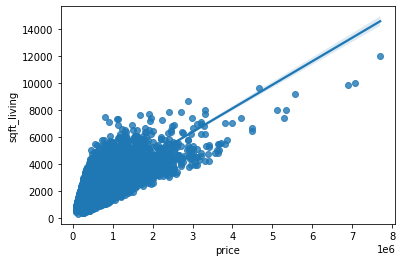

In [ ]:
sns.regplot(y="sqft_living", x="price", data=df)

Text(0.5, 0, 'Actual price')

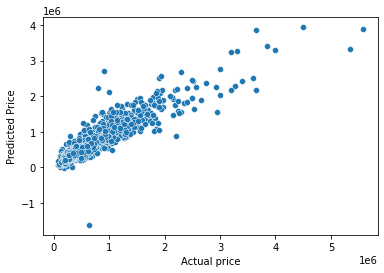

In [ ]:
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel("Predicted Price")
plt.xlabel("Actual price")

<AxesSubplot:xlabel='price'>

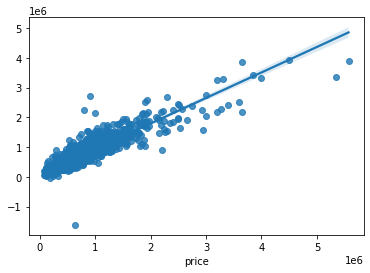

In [ ]:
sns.regplot(x=y_test, y=y_pred)

## T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(2)
preprocessor_result = preprocessor.fit_transform(X_train)
tsne_result = tsne.fit_transform(preprocessor_result)

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
tsne_result.shape

(17289, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


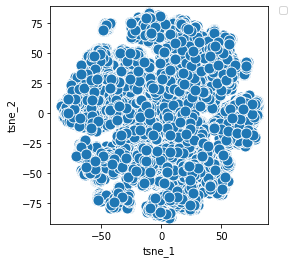

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})#, 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# PCA

- Scree plot of eigenvalues
- Correlation circle
- Pca projection
- Change price into a few groups

In [ ]:
X_acp = preprocessor.fit_transform(X, y)

2022/03/11 15:13:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17dac5ce9d7e4024b1ddc42285c712a8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/11 15:13:28 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/03/11 15:13:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'baa73080bd1847bca5de68e143c3068d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/11 15:13:31 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/03/11 15:13:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2b30ec4fc714

array([[ 0.        , -0.38793076, -0.75286396, ..., -0.55213528,
        -0.61113966, -0.64495462],
       [ 0.        , -0.11267727,  0.67244019, ..., -0.68755997,
        -0.05253446,  0.60959917],
       [ 0.        ,  0.24513645, -1.75116213, ..., -1.29353868,
        -1.3766622 , -1.4003575 ],
       ...,
       [ 0.        , -1.97487507, -1.09367436, ...,  1.30324547,
         1.30459981,  1.24546019],
       [ 0.        , -1.34272029, -0.04055434, ...,  1.12932736,
         1.12502384,  1.06825809],
       [ 0.        , -2.22624399, -1.09367436, ...,  1.26842717,
         1.26864882,  1.20998444]])